__Author__: Tomislav Suhina


__Goal__: Explore churn dataset, create pipeline prototype.

In [1]:
%config IPCompleter.use_jedi=False

In [3]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.display import display
from scipy import stats
from sklearn import (
    compose,
    dummy,
    feature_selection,
    impute,
    metrics,
    model_selection,
    pipeline,
    preprocessing,
)
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

c:\Users\PapanikolopoulosSiaA\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Settings to apply in notebook:
pd.set_option("display.max_columns", 500)
plt.rcParams["figure.figsize"] = (10, 4)
sns.set(style="whitegrid", font_scale=1.5)

In [5]:
# Reproducibility:
rng = np.random.seed(101)

## Load dataset into pandas

In [8]:
import os 
os.chdir()
churn_df = pd.read_csv("/data/input/case_churn.csv", sep=";")

display(churn_df.info(memory_usage=True))

display(churn_df.sample(5))

FileNotFoundError: [Errno 2] No such file or directory: '/data/input/case_churn.csv'

Data appears to be a single snapshot of the database, and therefore cannot be treated as a time-series.

__Gender information__ is likely a __sensitive__ feature, so I will drop this:

In [ ]:
churn_df = churn_df.drop(columns=["gender"])

Harmonize feature naming:

In [ ]:
def adapt_colnames(dataf: pd.DataFrame) -> pd.DataFrame:
    """Converts colnames to snake-case."""
    dataf = dataf.copy()
    dataf.columns = [col.replace(" ", "_").lower() for col in dataf.columns]
    return dataf

In [2]:
churn_df = churn_df.pipe(adapt_colnames)

display(churn_df.head())

NameError: name 'churn_df' is not defined

# Explorative data analysis

## Basic profiling and missing entries

### One entry per customer?

In [9]:
# Unique entry per customer?
assert churn_df["customerid"].nunique() == len(churn_df)

### Cast data types
There is a number of categorical features currently being parsed as `object` type. Not all features are parsed into dtypes that we'd expect, we will need to make functionality to cast data to expected types.

One example is `totalcharges`, where we encounter mosthly numbers but due to presence of an empty string it is parsed as object by default.

In [10]:
churn_df.dtypes

customerid                        int64
seniorcitizen                     int64
partner                          object
dependents                       object
age                               int64
tenure                            int64
busines_loan                     object
multiplebusinessloans            object
creditline                       object
online_banking                   object
mortgage                         object
stocks                           object
forex                            object
contract                         object
paperlessbilling                 object
paymentmethod                    object
monthlycharges                  float64
totalcharges                     object
churn_within_a_month             object
satisfactory_onboarding_form      int64
dtype: object

In [11]:
# Cast data to adequate types to improve memory footprint:
parsing_fns = {
    "customerid": lambda df: df["customerid"].astype("category"),
    "seniorcitizen": lambda df: df["seniorcitizen"].astype("category"),
    "partner": lambda df: df["partner"].astype("category"),
    "dependents": lambda df: df["dependents"].astype("category"),
    "age": lambda df: pd.to_numeric(df["age"], errors="coerce"),
    "tenure": lambda df: pd.to_numeric(df["tenure"], errors="coerce"),
    "busines_loan": lambda df: df["busines_loan"].astype("category"),
    "multiplebusinessloans": lambda df: df["multiplebusinessloans"].astype("category"),
    "creditline": lambda df: df["creditline"].astype("category"),
    "online_banking": lambda df: df["online_banking"].astype("category"),
    "mortgage": lambda df: df["mortgage"].astype("category"),
    "stocks": lambda df: df["stocks"].astype("category"),
    "forex": lambda df: df["forex"].astype("category"),
    "contract": lambda df: df["contract"].astype("category"),
    "paperlessbilling": lambda df: df["paperlessbilling"].astype("category"),
    "paymentmethod": lambda df: df["paymentmethod"].astype("category"),
    "monthlycharges": lambda df: pd.to_numeric(df["monthlycharges"], errors="coerce"),
    "totalcharges": lambda df: pd.to_numeric(df["totalcharges"], errors="coerce"),
    "churn_within_a_month": lambda df: df["churn_within_a_month"].astype("category"),
    "satisfactory_onboarding_form": lambda df: pd.to_numeric(
        df["satisfactory_onboarding_form"]
    ),
}

print(f"Memory footprint before casting: {churn_df.memory_usage(deep=True).sum()/(1024**2)}")
# Cast types:
churn_df = churn_df.assign(**parsing_fns)
print(f"Memory footprint after casting: {churn_df.memory_usage(deep=True).sum()/(1024**2)}")

Memory footprint before casting: 6.011689186096191
Memory footprint after casting: 0.6854009628295898


### Number of entries and features:

In [12]:
print(churn_df.shape)

(7043, 20)


### Missing data:
Features `multiplebusinessloans` and `onlinebanking` contain some missing entries. We should either need to impute, or logically deduce those (perhaps a good point to discuss with business).

For the sake of simplicity, I will impute those later using methods available in scikit-learn.

In [13]:
(churn_df.isnull().mean().to_frame().rename(columns={0: "frac_missing"}))

,frac_missing
customerid,0.000000
seniorcitizen,0.000000
partner,0.000000
dependents,0.000000
age,0.000000
tenure,0.000000
busines_loan,0.000000
multiplebusinessloans,0.096834
creditline,0.000000
online_banking,0.216669


### Aggregate statistics

In [14]:
(churn_df.describe(include=np.number).T)

,count,mean,std,min,25%,50%,75%,max
age,7043.0,44.917081,19.489682,18.00,30.00,42.000,55.0000,100.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
monthlycharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
satisfactory_onboarding_form,7043.0,3.008093,1.409715,1.00,2.00,3.000,4.0000,5.00


In [15]:
(churn_df.describe(include=pd.CategoricalDtype).T)

,count,unique,top,freq
customerid,7043,7043,1,1
seniorcitizen,7043,2,0,5901
partner,7043,2,No,3641
dependents,7043,2,No,4933
busines_loan,7043,2,Yes,6361
multiplebusinessloans,6361,2,No,3390
creditline,7043,3,A,3096
online_banking,5517,2,No,3498
mortgage,7043,2,No,4999
stocks,7043,3,No,2810


## Checking effects of various features on response

Convert response column to numeric for easier exploration:

### Monthly opportunity lost due to churn

In [16]:
churn_df_eda = churn_df.assign(
    churn_within_a_month=lambda df: df["churn_within_a_month"]
    .map({"Yes": 1, "No": 0})
    .astype(int)
)

display(churn_df_eda.head())

,customerid,seniorcitizen,partner,dependents,age,tenure,busines_loan,multiplebusinessloans,creditline,online_banking,mortgage,stocks,forex,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn_within_a_month,satisfactory_onboarding_form
0,1,0,Yes,No,35,1,No,NaN,B,No,No,No,No,A,Yes,Electronic check,29.85,29.85,0,4
1,2,0,No,No,46,34,Yes,No,B,Yes,No,No,No,B,No,Mailed check,56.95,1889.50,0,2
2,3,0,No,No,41,2,Yes,No,B,Yes,No,No,No,A,Yes,Mailed check,53.85,108.15,1,3
3,4,0,No,No,40,45,No,NaN,B,Yes,Yes,No,No,B,No,Bank transfer (automatic),42.30,1840.75,0,1
4,5,0,No,No,59,2,Yes,No,A,No,No,No,No,A,Yes,Electronic check,70.70,151.65,1,5


## Client Acquisition

In [17]:
(
    churn_df_eda
    .assign(is_new=lambda df: df["tenure"]<1)
    .groupby("is_new")
    ["customerid"]
    .count()
    # .plot(kind="bar")
)
# plt.show()

is_new
False    7032
True       11
Name: customerid, dtype: int64

Not many new joiners!

## Client Churn

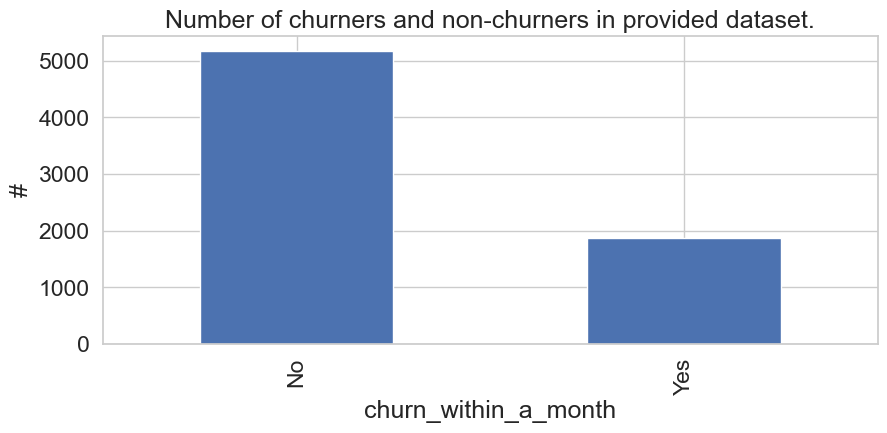

In [18]:
(
    churn_df
    .groupby("churn_within_a_month")
    ["customerid"]
    .count()
    .plot(kind="bar")
)

plt.title("Number of churners and non-churners in provided dataset.")
plt.ylabel("#")
plt.show()

__CRITICAL__: Is this just a snapshot for a month, or is this curated custom dataset?

If this is a snapshot, at this rate all clients will be gone soon!!!!

__ASSUMPTION__: I will assume this is a curated report prepared by analyst, specifically for the purpose of training the churn model.

In [19]:
(
    churn_df
    .groupby("churn_within_a_month")
    ["monthlycharges"]
    .sum()
    .to_frame()
    .assign(percentage_total=lambda df: np.round(100 * df["monthlycharges"] / df["monthlycharges"].sum(), 2))
)

,monthlycharges,percentage_total
churn_within_a_month,,
No,316985.75,69.5
Yes,139130.85,30.5


### Is churn rate higher for sub-populatior of senior clients?
It appears there is a considerable difference in churn rates between senior and not-senior samples.

I am choosing to not speculate about the reasons for this. There might be more to this story than meets the eye.

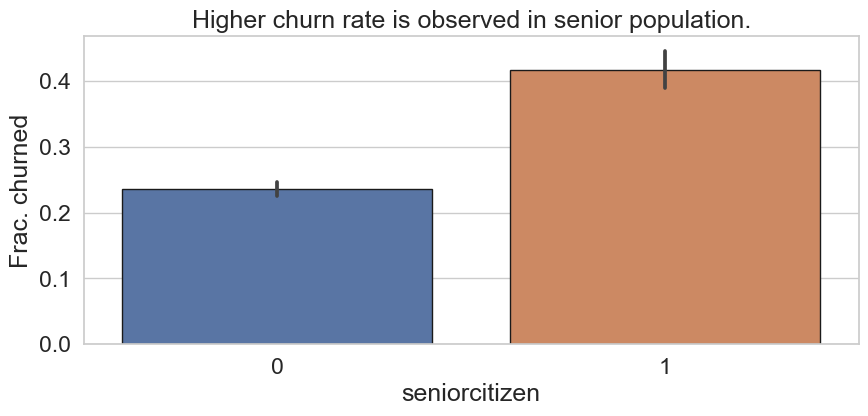

In [20]:
# Quick and dirty conversion to get what we need:
(sns.barplot(x="seniorcitizen", y="churn_within_a_month", data=churn_df_eda, ec="k"))

plt.title("Higher churn rate is observed in senior population.")
plt.ylabel("Frac. churned")

plt.show()

### Is there obvious reason to include `age` as explicit feature (or can we stick to `seniorcitizen`)?

Quick look at dependence `churn ~ age` (binned) indicates that it may not make too much sense to include age as a continuous feature.

I will remove `age` as a feature further down the line.

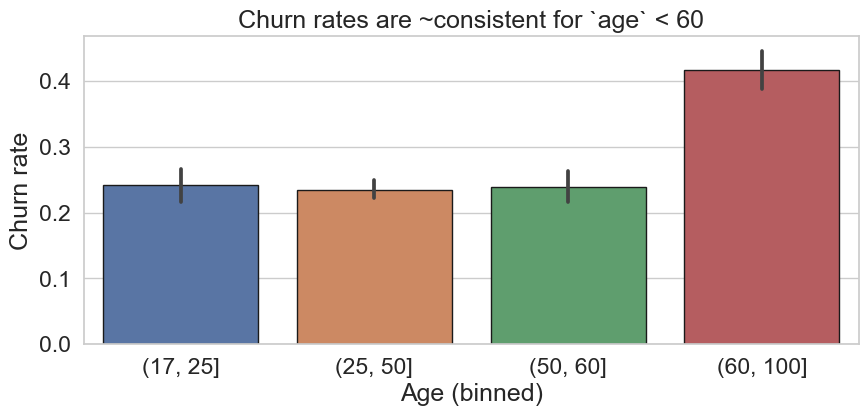

In [21]:
(
    sns.barplot(
        x="age",
        y="churn_within_a_month",
        data=churn_df_eda.assign(
            age=lambda df: pd.cut(df["age"], bins=[17, 25, 50, 60, 100])
        ),
        ec="k",
    )
)

plt.title("Churn rates are ~consistent for `age` < 60")
plt.xlabel("Age (binned)")
plt.ylabel("Churn rate")

plt.show()

### Is there obvious dependence between churn rate and `tenure`?

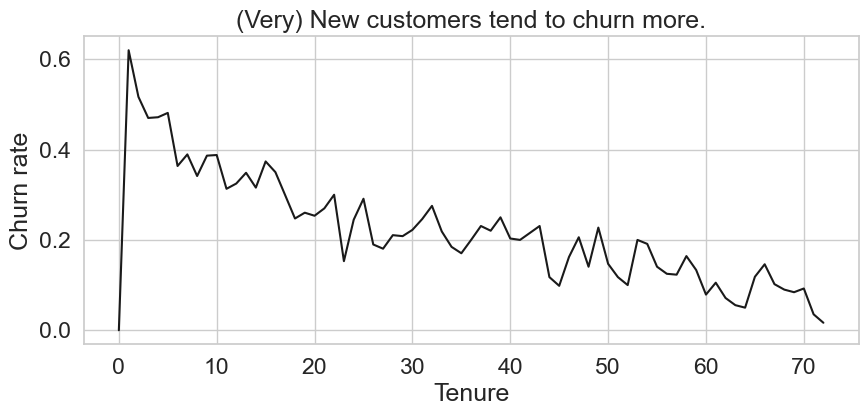

In [22]:
(
    churn_df_eda.assign(
        churn_within_a_month=lambda df: pd.to_numeric(df["churn_within_a_month"])
    )
    .groupby("tenure")["churn_within_a_month"]
    .mean()
    .plot(color="k")
)

plt.title("(Very) New customers tend to churn more.")
plt.ylabel("Churn rate")
plt.xlabel("Tenure")
plt.show()

### Do clients with `mortgage` churn less?

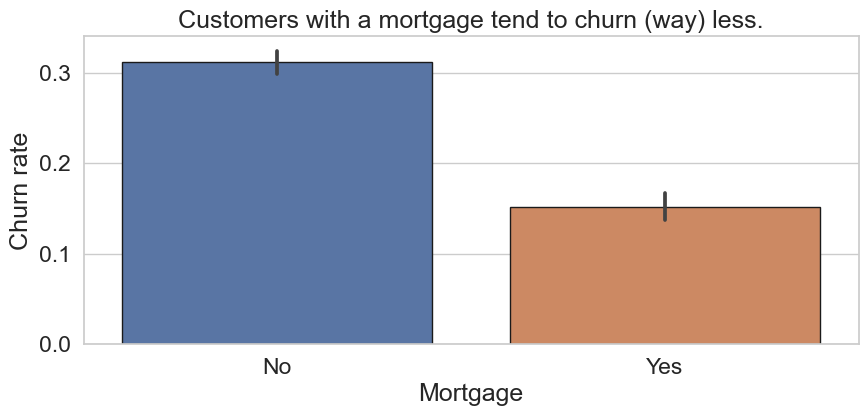

In [23]:
sns.barplot(x="mortgage", y="churn_within_a_month", data=churn_df_eda, ec="k")

plt.title("Customers with a mortgage tend to churn (way) less.")
plt.ylabel("Churn rate")
plt.xlabel("Mortgage")

plt.show()

### How do does churn rate vary across clients with different contracts?

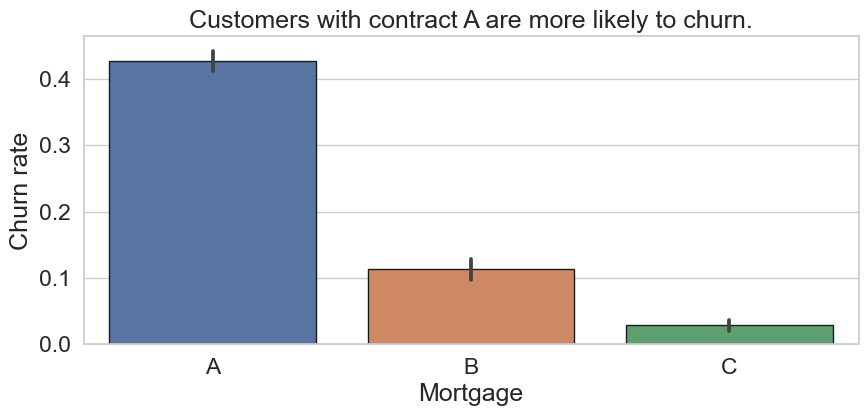

In [24]:
sns.barplot(x="contract", y="churn_within_a_month", data=churn_df_eda, ec="k")

plt.title("Customers with contract A are more likely to churn.")
plt.ylabel("Churn rate")
plt.xlabel("Mortgage")

plt.show()

### Does onboarding impact churn?

There is no obvious tendency to churn observable.

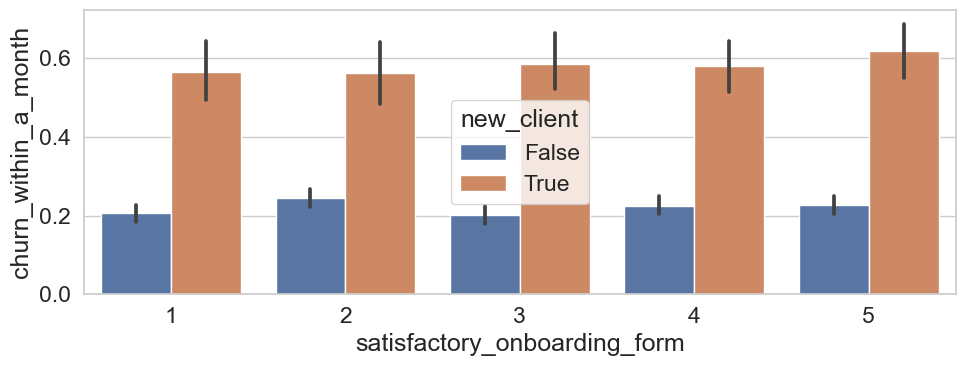

In [25]:
temp = (
    churn_df_eda
    .assign(new_client=lambda df: df["tenure"].lt(3))
)

sns.barplot(data=temp, x="satisfactory_onboarding_form", y="churn_within_a_month", hue="new_client")

plt.tight_layout()

plt.show()

### Under-represented categories and churn tendency

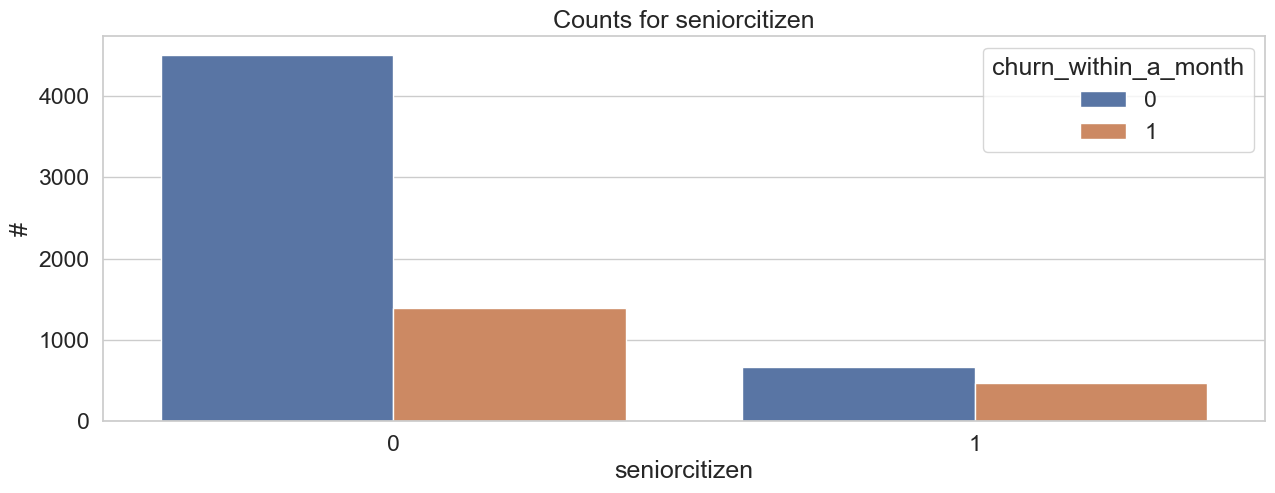

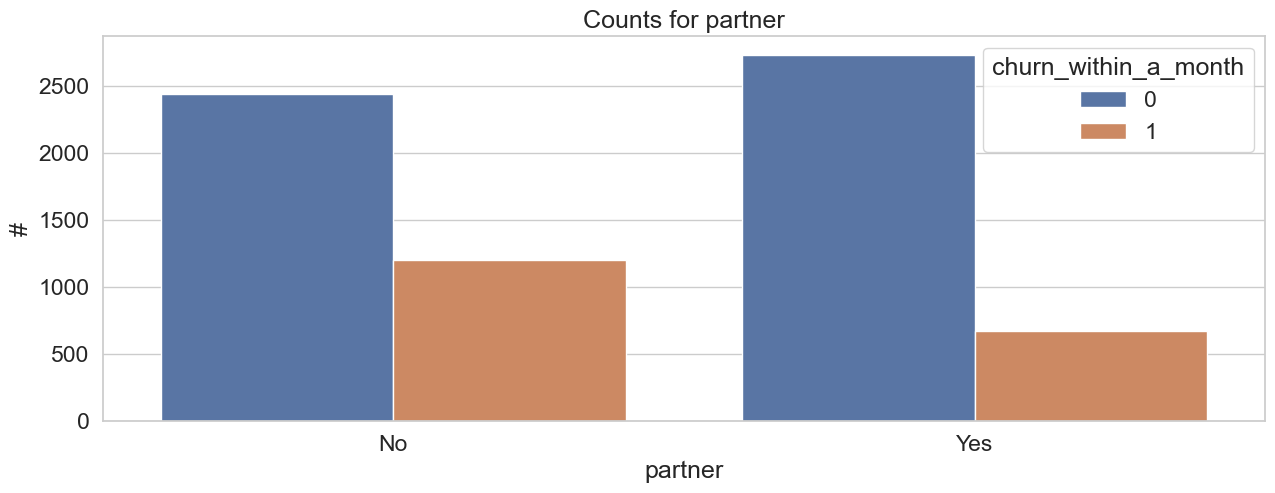

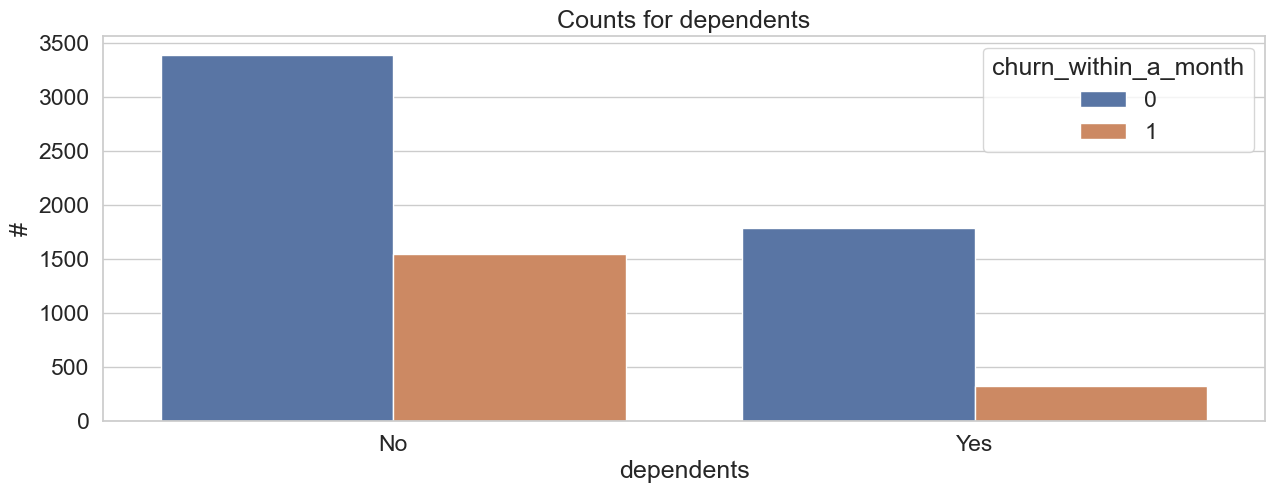

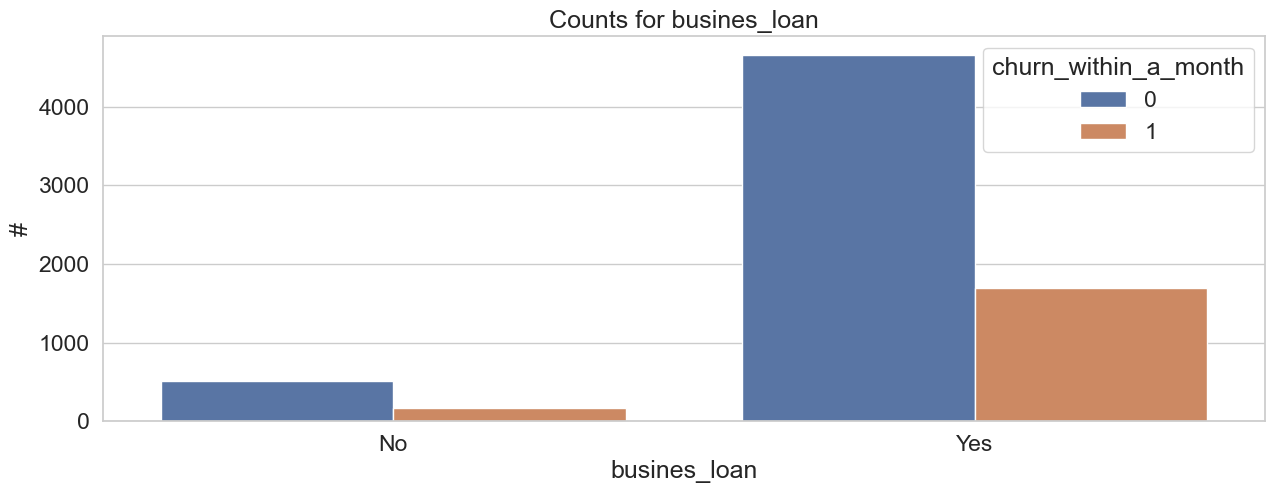

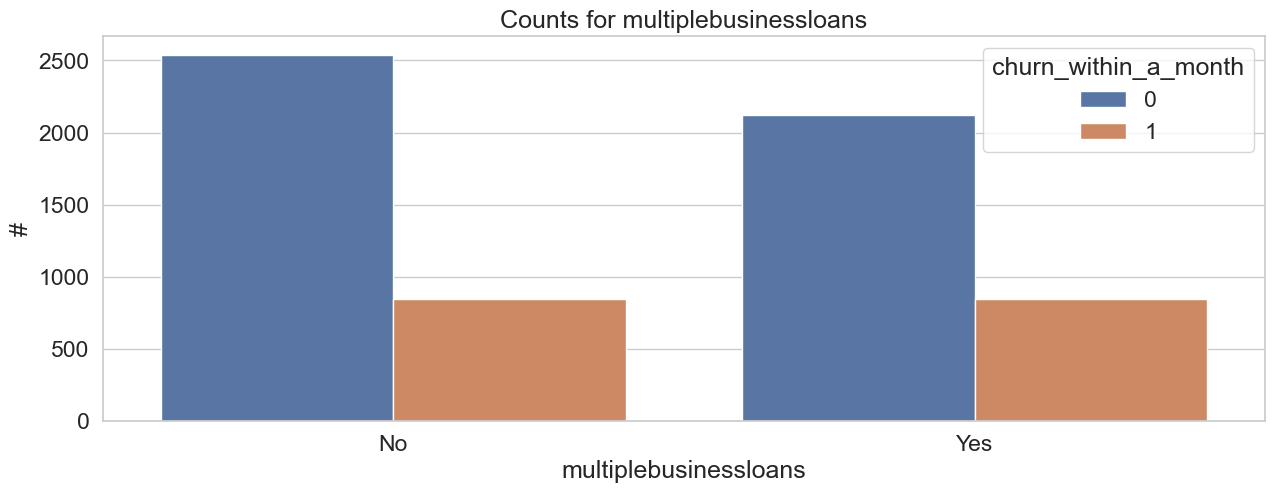

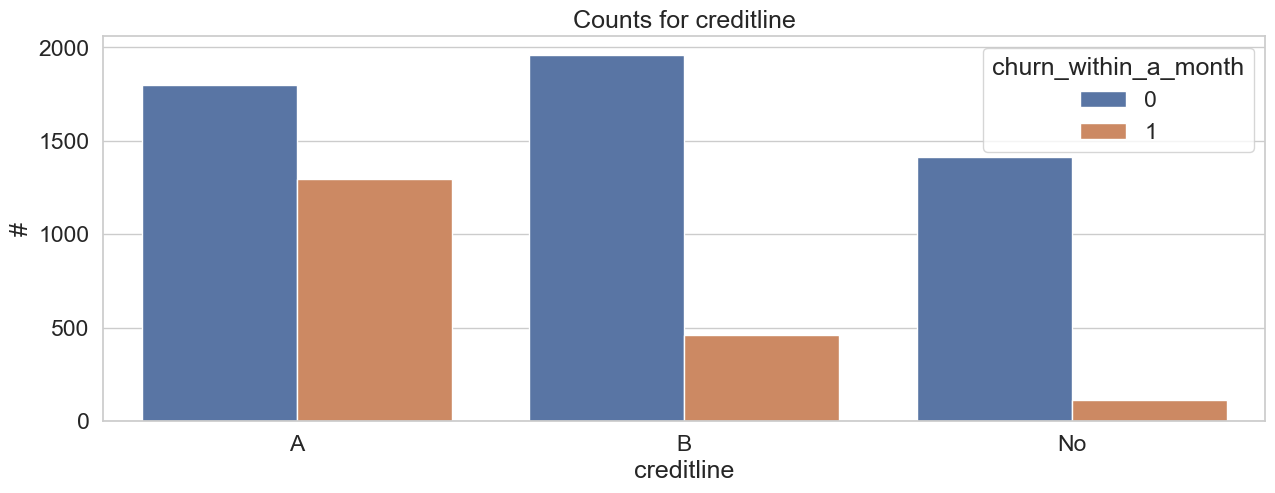

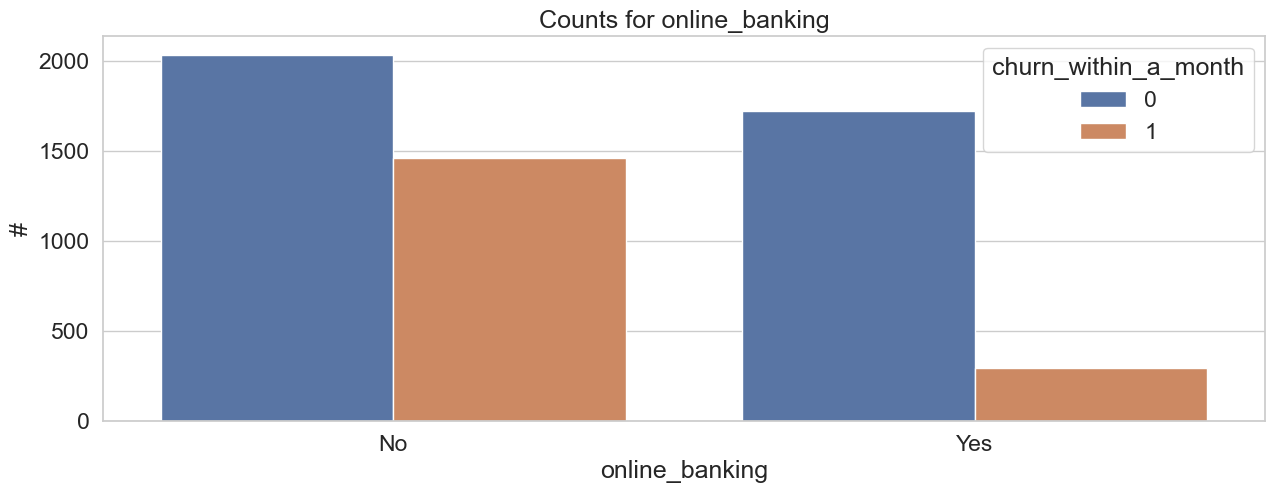

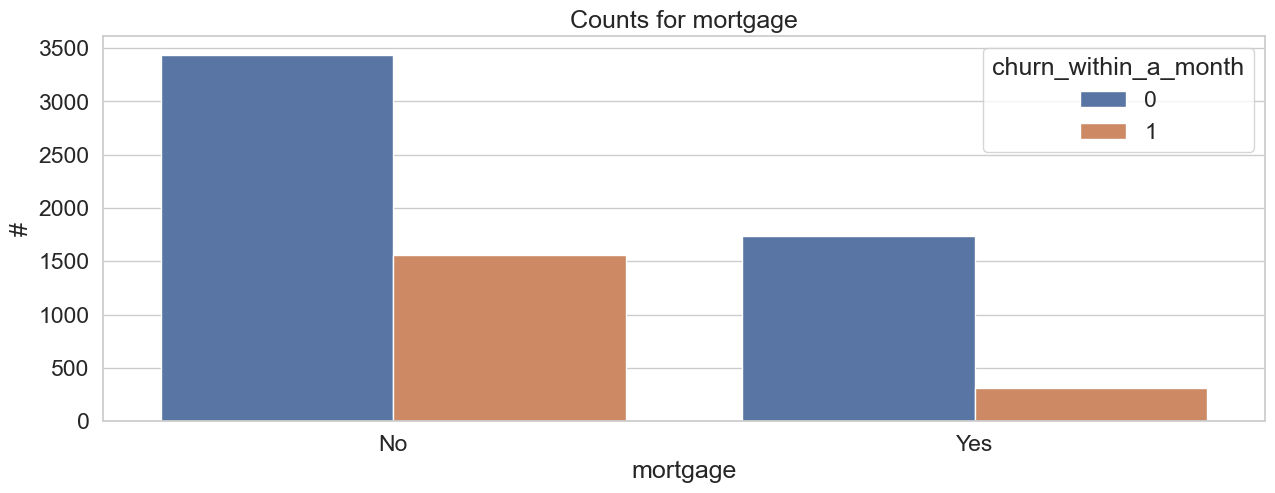

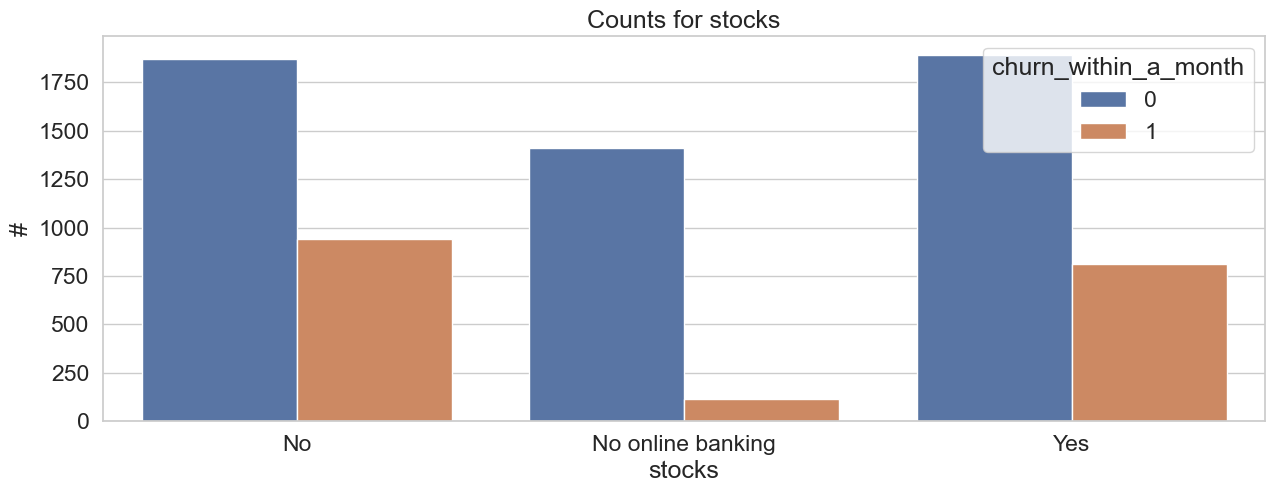

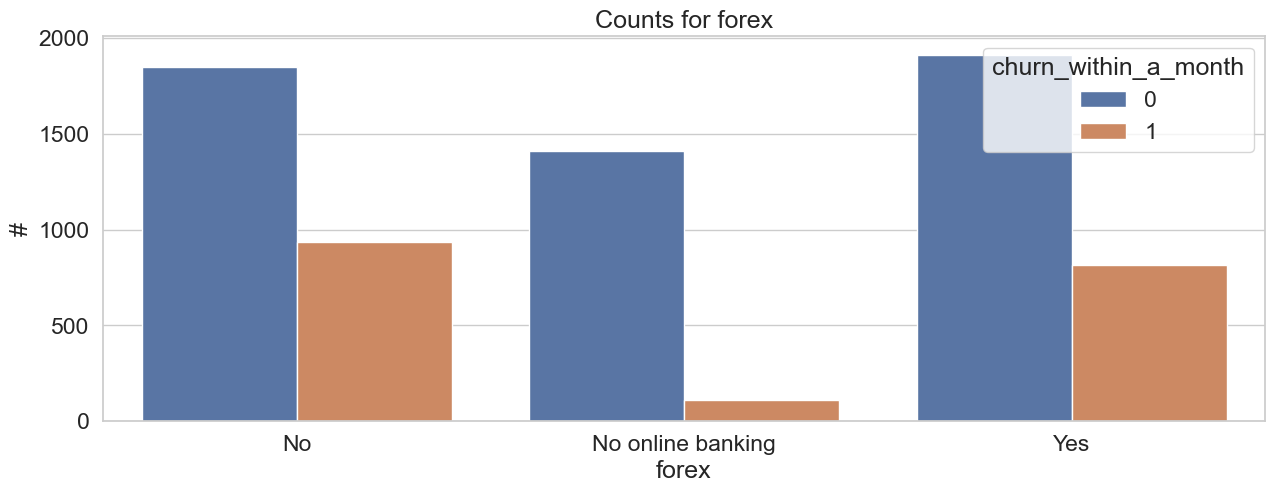

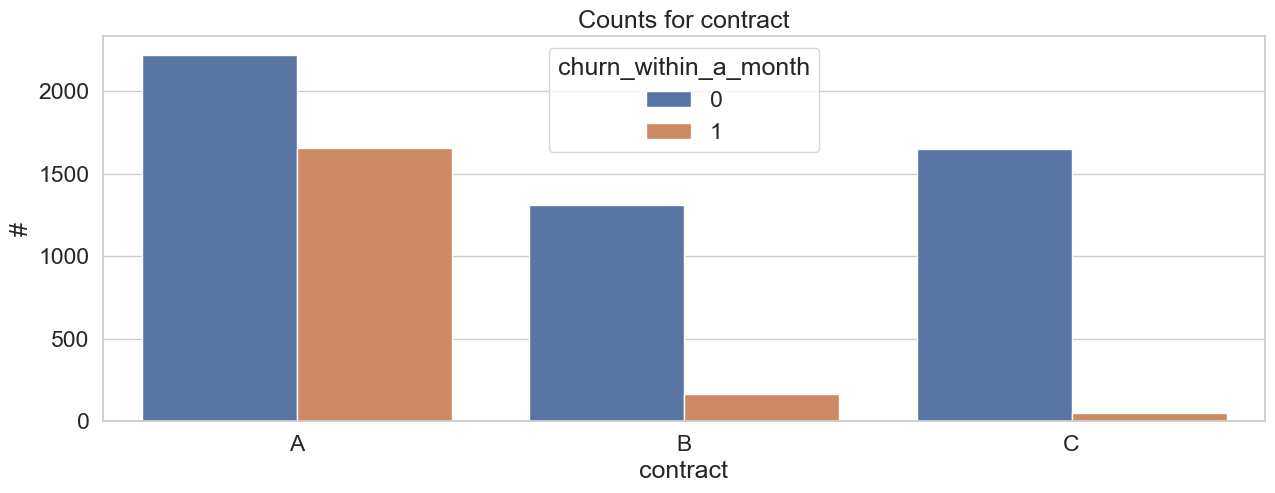

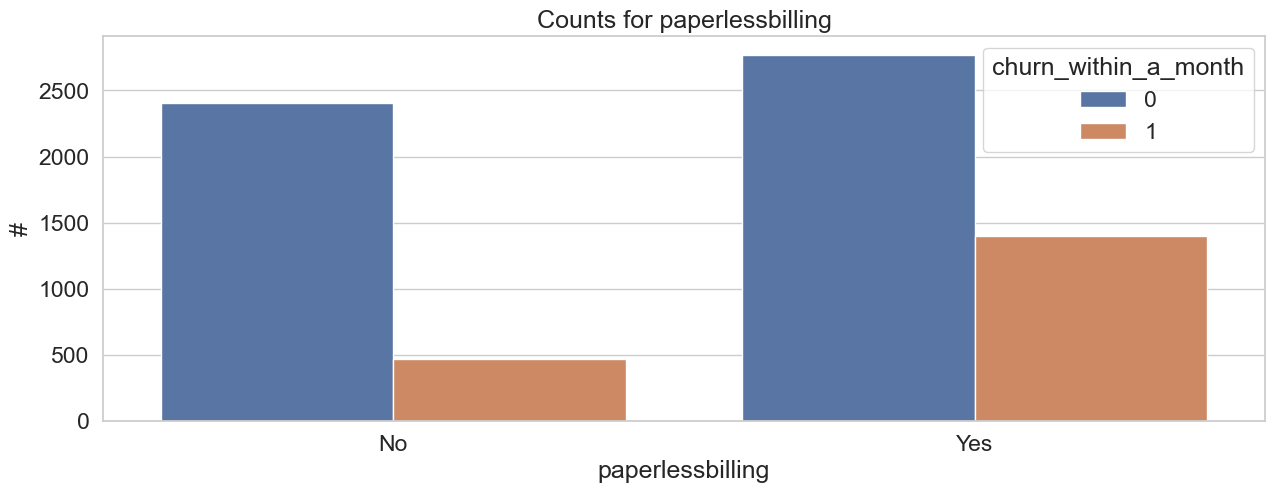

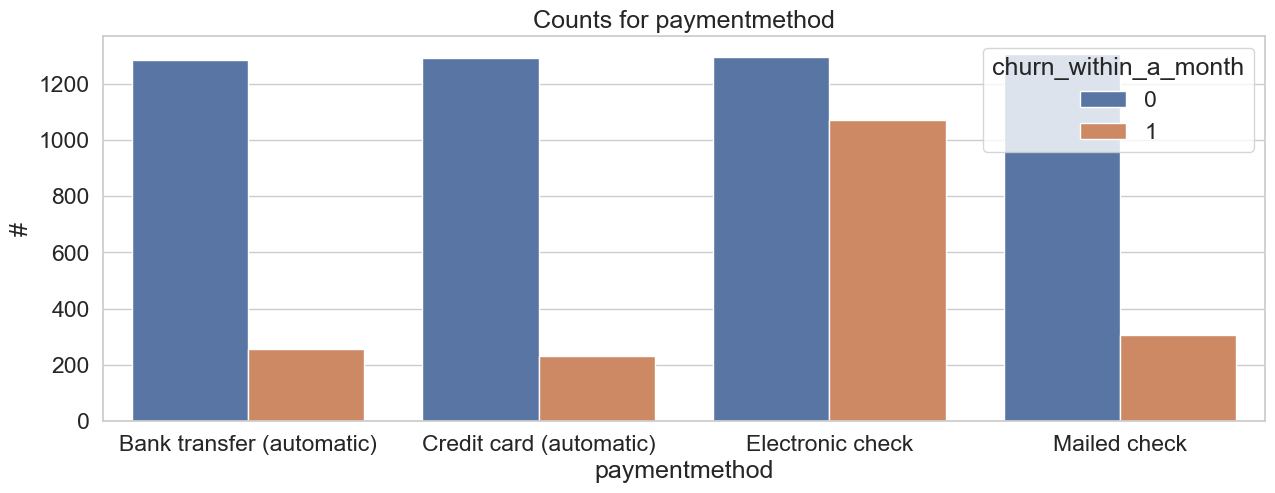

In [26]:
CATEGORICAL = [
    "seniorcitizen",
    "partner",
    "dependents",
    "busines_loan",
    "multiplebusinessloans",
    "creditline",
    "online_banking",
    "mortgage",
    "stocks",
    "forex",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

for col in CATEGORICAL:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.countplot(x=col, data=churn_df_eda, hue="churn_within_a_month")
    ax.set_title(f"Counts for {col}")
    ax.set_ylabel("#")
plt.show()

### Outliers

I will only explore the most basic outliers. Better way would be to do it using multivariate analysis (PyOD package or similar).

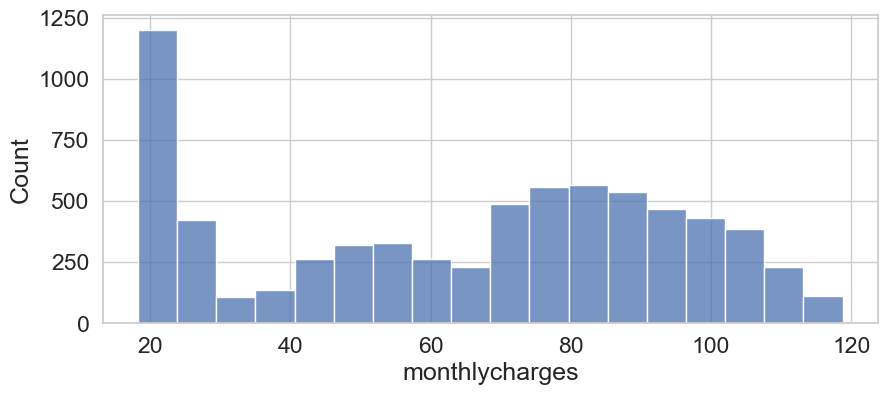

In [27]:
sns.histplot(data=churn_df, x="monthlycharges")
plt.show()

# Model

## Features

In [28]:
NUMERIC = [
    # "age",
    "tenure",
    "monthlycharges",
    # "totalcharges",
    "satisfactory_onboarding_form",  # could also be ordered categorical, but yeah..
]

CATEGORICAL = [
    "seniorcitizen",
    "partner",
    "dependents",
    "busines_loan",
    # "multiplebusinessloans",
    "creditline",
    "online_banking",
    "mortgage",
    "stocks",
    "forex",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

RESPONSE = ["churn_within_a_month"]

## Hold-out set and target encoding

In [29]:
X = churn_df[[col for col in churn_df.columns if col != RESPONSE]]
y = churn_df[RESPONSE]

# Using sklearn.compose.TransformedTargetRegressor makes
# validation more challenging, so not using it here.
label_enc = preprocessing.LabelEncoder().fit(y.to_numpy().ravel())

y = label_enc.transform(y.to_numpy().ravel())

# Save part of data as hold-out set:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.80, random_state=rng
)

## A model to beat - baseline

In [30]:
baseline_model = dummy.DummyClassifier(strategy="stratified", random_state=rng).fit(
    X_train, y_train
)

preds_train_baseline = baseline_model.predict(X_train)
preds_test_baseline = baseline_model.predict(X_test)

print("Train:")
print(metrics.classification_report(y_train, preds_train_baseline))
print("\n\nTest:")
print(metrics.classification_report(y_test, preds_test_baseline))

Train:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4134
           1       0.26      0.26      0.26      1500

    accuracy                           0.60      5634
   macro avg       0.49      0.49      0.49      5634
weighted avg       0.60      0.60      0.60      5634



Test:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1040
           1       0.27      0.26      0.27       369

    accuracy                           0.62      1409
   macro avg       0.51      0.51      0.51      1409
weighted avg       0.62      0.62      0.62      1409



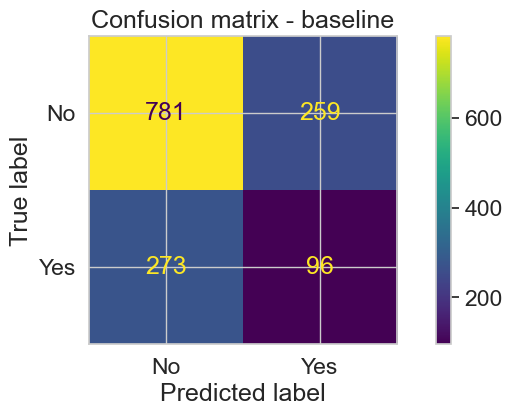

In [31]:
cm = metrics.confusion_matrix(y_test, preds_test_baseline)

metrics.ConfusionMatrixDisplay(cm, display_labels=label_enc.classes_).plot()

plt.title("Confusion matrix - baseline")

plt.show()

## Model pipeline

In [32]:
# NOTE: It is more efficient to implement Grad boost by having it treat categorical features
# without OHE. Here this was a choice, as it allows flexibility to test more models!
scaler = preprocessing.StandardScaler()

ohe = preprocessing.OneHotEncoder(
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
    min_frequency=10,
    drop="if_binary",
)

# rfe_selector = RandomForestClassifier(
#     random_state=rng, class_weight="balanced", n_jobs=1, max_depth=5
# )

numeric_transformer = pipeline.Pipeline(
    steps=[
        ("imputer_num", impute.KNNImputer(n_neighbors=5, add_indicator=True)),
        ("scaler", scaler),
    ]
)

cat_transformer = pipeline.Pipeline(
    steps=[
        ("cat_impute", impute.SimpleImputer(strategy="most_frequent")),
        ("one_hot", ohe),
    ]
)

transformer = compose.ColumnTransformer(
    transformers=[
        ("numeric_preprocess", numeric_transformer, NUMERIC),
        ("categorical_preprocess", cat_transformer, CATEGORICAL),
    ],
    remainder="drop",
)

cls_pipeline = pipeline.Pipeline(
    steps=[
        ("transformer", transformer),
        #("rfe", feature_selection.RFE(estimator=rfe_selector, n_features_to_select=12)),
        ("regressor", HistGradientBoostingClassifier()),
    ]
)

In [33]:
display(cls_pipeline)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric_preprocess',
                                                  Pipeline(steps=[('imputer_num',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthlycharges',
                                                   'satisfactory_onboarding_form']),
                                                 ('categorical_preprocess',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=10,
                                                                                 sparse_output=False))]),
                                                  ['seniorcitizen', 'partner',
                                                   'dependents', 'busines_loan',
                                                   'creditline',
                                                   'online_banking', 'mortgage',
                                                   'stocks', 'forex',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('regressor', HistGradientBoostingClassifier())])

In [34]:
parameters = {
    "regressor__learning_rate": stats.uniform(0.01, 0.5),
    "regressor__max_depth": stats.randint(3, 8),
    "regressor__max_iter": stats.randint(100, 800),
    "regressor__l2_regularization": stats.uniform(0.5, 15),
    "regressor__max_bins": stats.randint(50, 255),
    "regressor__class_weight": ["balanced", None],
    "regressor__early_stopping": [True],
    "regressor__n_iter_no_change": [5],
    #"rfe__n_features_to_select": stats.randint(5, 15),
}

# TODO: Perhaps use bayesian search (optuna, scikit-optimize, ..)
cv_res = model_selection.RandomizedSearchCV(
    estimator=cls_pipeline,
    param_distributions=parameters,
    n_jobs=-1,
    scoring="f1",
    random_state=rng,
    n_iter=150,
).fit(X_train, y_train)

# We take the best estimator for later use!
model = cv_res.best_estimator_

In [35]:
cv_res = model_selection.cross_validate(
    model,
    X_train,
    y_train,
    cv=model_selection.StratifiedKFold(random_state=rng),
    scoring=["precision", "recall", "f1", "accuracy"],
)

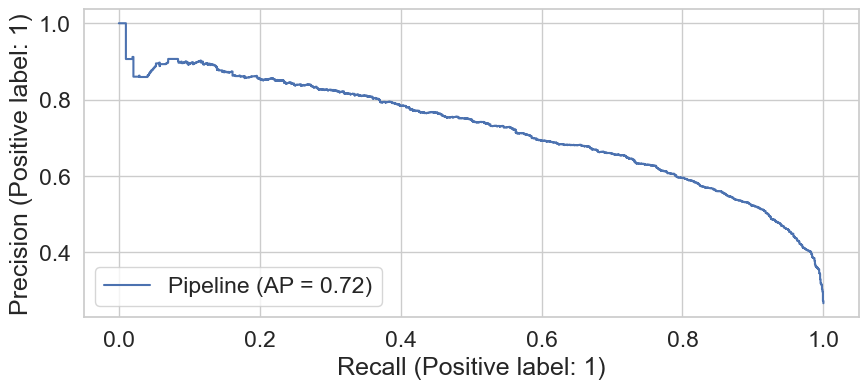

In [36]:
metrics.PrecisionRecallDisplay.from_estimator(model, X_train, y_train)
plt.show()

In [37]:
# We can adapt this to achieve desired balance betweeen
# precision and recall:
THRESHOLD = 0.55

preds_train = model.predict_proba(X_train)[:, 1] > THRESHOLD
preds_test = model.predict_proba(X_test)[:, 1] > THRESHOLD

In [38]:
print("Train:")
print(metrics.classification_report(y_train, preds_train))

print("\n\nTest:")
print(metrics.classification_report(y_test, preds_test))

Train:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      4134
           1       0.59      0.81      0.68      1500

    accuracy                           0.80      5634
   macro avg       0.75      0.80      0.77      5634
weighted avg       0.83      0.80      0.81      5634



Test:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1040
           1       0.52      0.76      0.62       369

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.77      1409



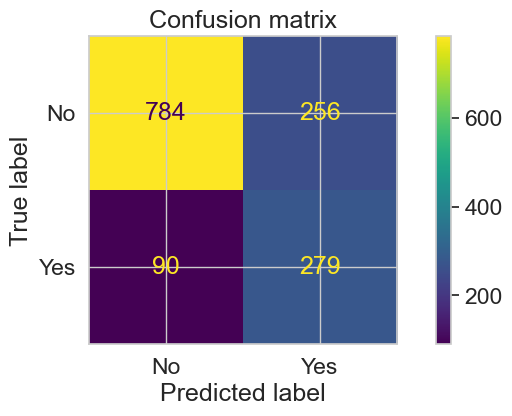

In [39]:
cm = metrics.confusion_matrix(y_test, preds_test)

metrics.ConfusionMatrixDisplay(cm, display_labels=label_enc.classes_).plot()

plt.title("Confusion matrix")

plt.show()

It turns out that we have improved on the baseline model considerably! Now we can identify a good part of the churners, meaning that we can target them for retention purposes!|

## Model explanations

In [40]:
transformed_data = model[:-1].transform(X)
predict_func = lambda x: model[-1].predict_proba(x)[:, 1]
med = np.median(transformed_data, axis=0).reshape((1, transformed_data.shape[1]))

explainer = shap.KernelExplainer(model=predict_func, data=med)
shap_values = explainer.shap_values(X=transformed_data)

  0%|          | 0/7043 [00:00<?, ?it/s]

In [41]:
model[:-1].get_feature_names_out()

array(['numeric_preprocess__tenure', 'numeric_preprocess__monthlycharges',
       'numeric_preprocess__satisfactory_onboarding_form',
       'categorical_preprocess__seniorcitizen_1',
       'categorical_preprocess__partner_Yes',
       'categorical_preprocess__dependents_Yes',
       'categorical_preprocess__busines_loan_Yes',
       'categorical_preprocess__creditline_A',
       'categorical_preprocess__creditline_B',
       'categorical_preprocess__creditline_No',
       'categorical_preprocess__online_banking_Yes',
       'categorical_preprocess__mortgage_Yes',
       'categorical_preprocess__stocks_No',
       'categorical_preprocess__stocks_No online banking',
       'categorical_preprocess__stocks_Yes',
       'categorical_preprocess__forex_No',
       'categorical_preprocess__forex_No online banking',
       'categorical_preprocess__forex_Yes',
       'categorical_preprocess__contract_A',
       'categorical_preprocess__contract_B',
       'categorical_preprocess__contract_C',


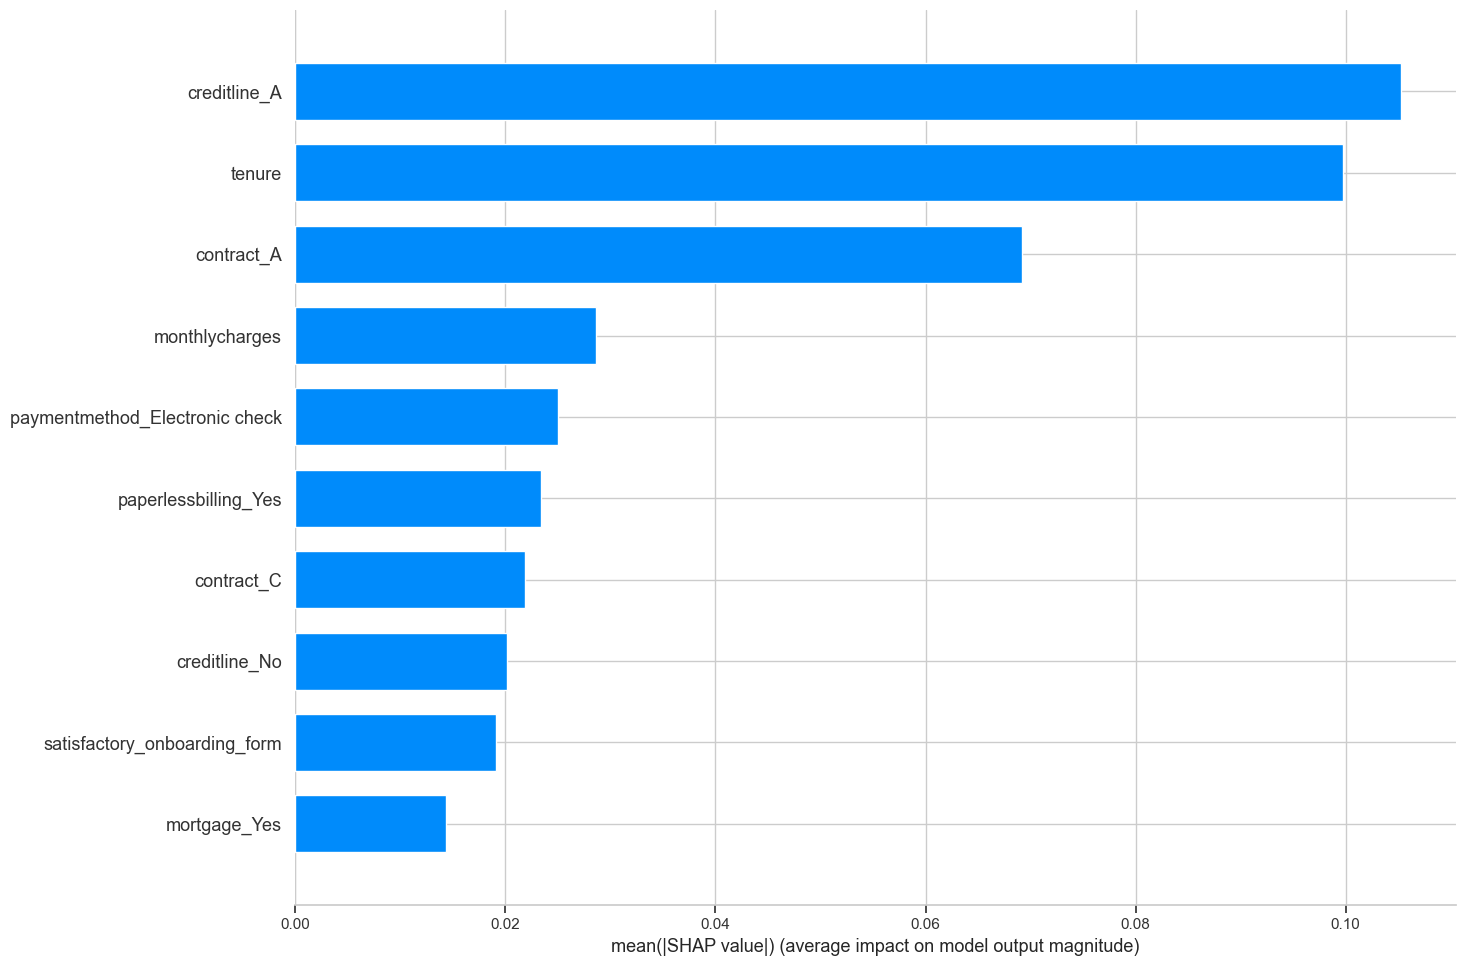

In [42]:
feature_names = [
    feature.split("__")[-1] for feature in model[:-1].get_feature_names_out()
]

shap.summary_plot(
    shap_values,
    transformed_data,
    feature_names=[
        feature.split("__")[-1] for feature in model[:-1].get_feature_names_out()
    ],
    plot_type="bar",
    title="Feature importance (shap)",
    plot_size=(15, 10),
    max_display=10,
    show=False,
)

plt.savefig("../artefacts/figures/feature_importance.png", dpi=600)

plt.show()

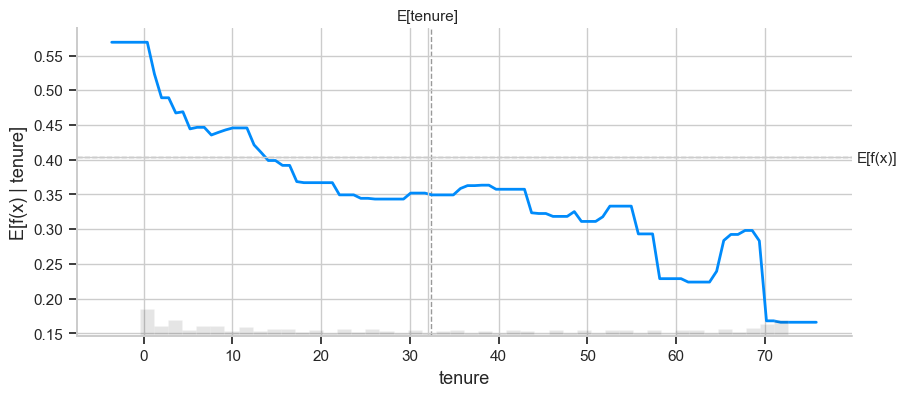

In [43]:
shap.partial_dependence_plot(
    "tenure",
    lambda x: model[-1].predict_proba(model[:-1].transform(x))[:, 1],
    data=X,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    show=False,
)

plt.savefig("../artefacts/figures/impact_tenure.png", dpi=600)

plt.show()

In [44]:
churn_df.columns

Index(['customerid', 'seniorcitizen', 'partner', 'dependents', 'age', 'tenure',
       'busines_loan', 'multiplebusinessloans', 'creditline', 'online_banking',
       'mortgage', 'stocks', 'forex', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges',
       'churn_within_a_month', 'satisfactory_onboarding_form'],
      dtype='object')

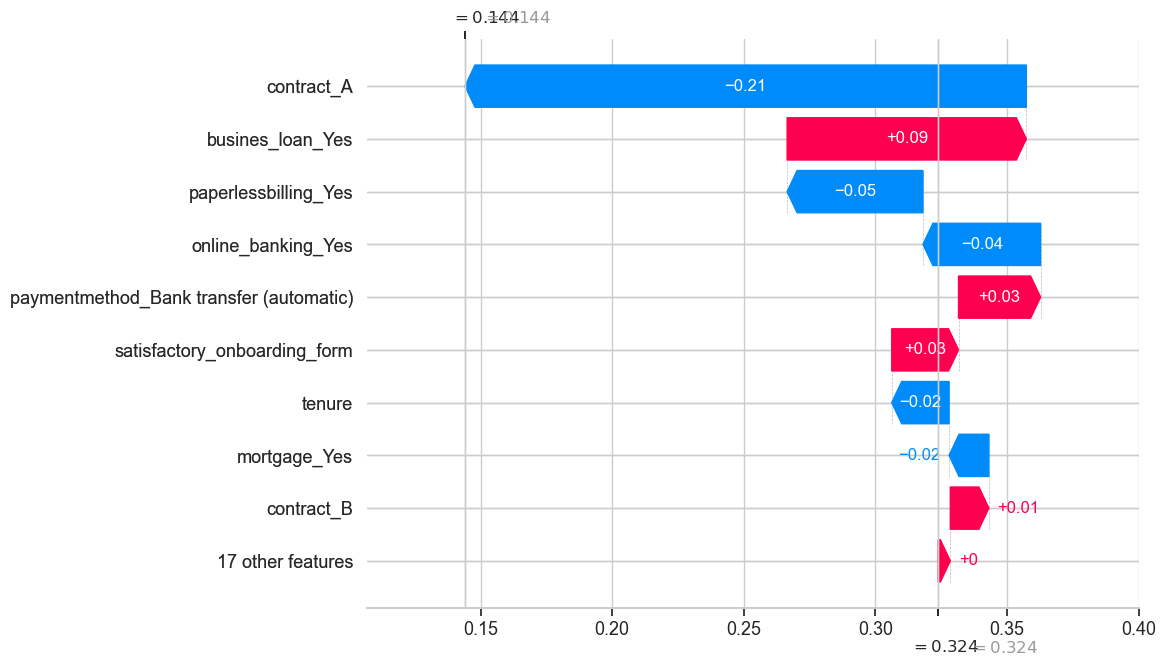

In [45]:
fig = plt.figure()
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[3],
    feature_names=[
        feature.split("__")[-1] for feature in model[:-1].get_feature_names_out()
    ],
    show=False,
)

plt.gcf().set_size_inches(12, 7)
plt.tight_layout()

plt.savefig("../artefacts/figures/explanation_0.png", dpi=600)

plt.show()

In [46]:
X.iloc[3, :].to_frame()

,3
customerid,4
seniorcitizen,0
partner,No
dependents,No
age,40
tenure,45
busines_loan,No
multiplebusinessloans,NaN
creditline,B
online_banking,Yes
